# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from datetime import datetime
from tqdm import tqdm

# Variables

In [2]:
BASE_TICKER_PATH = 'assets'

# Functions

In [3]:
def extract_date_from(path):
    fields = [int(field) for field in path[-14:-4].split('-')]
    return datetime(*fields)

In [4]:
def extract_data_files_from(ticker):
    return sorted(
        [
            extract_date_from(str(path))
            for path in Path(f'{BASE_TICKER_PATH}/{ticker}').glob('*.csv')
        ]
    )

In [5]:
def load_data(ticker):
    data = pd.concat([
        pd.read_csv(
            f'{BASE_TICKER_PATH}/{ticker}/{str(date_).split()[0]}.csv'
        )
        for date_ in extract_data_files_from(ticker)
    ])

    data['Date'] = data['Date'].map(lambda v: v.split()[0])
    data = data.set_index('Date')
    data.index = pd.to_datetime(data.index, utc=True)
    return data

# Main

### Questions

- Are asset classes really historically uncorrelated?
- Have they always been uncorrelated throughout time?
- Is the performance of the portfolio better than isolated assets or subsets?
- Does it perform well at "every time"?

### Code

In [6]:
def build_features(data):
    data['DayToDay_Var'] = np.log(data['Close'] / data['Close'].shift(1))
    return data

In [7]:
def loading_pipeline(ticker):
    return build_features(load_data(ticker))

In [8]:
def merge_two_assets_data(assets_data, ticker_a, ticker_b, column_to_use):
    merged_assets_returns_data = pd.merge(
        assets_data[ticker_a][[column_to_use]],
        assets_data[ticker_b][[column_to_use]],
        left_index=True, right_index=True
    ).dropna()
    merged_assets_returns_data.columns = [ticker_a, ticker_b]
    return merged_assets_returns_data

In [9]:
tickers = (
    'GLD',
    'TLT',
    'IEF',
    'VTI',
    'DBC',
)

assets_data = {
    ticker: loading_pipeline(ticker)
    for ticker in tickers
}

#### Are asset classes really historically uncorrelated?

In [10]:
from itertools import combinations, product

In [11]:
def correlation_between(ticker_a, ticker_b, column_to_use, assets_data):
    correlation_matrix = merge_two_assets_data(
        assets_data, ticker_a, ticker_b, column_to_use
    ).corr()
    return correlation_matrix.loc[ticker_a, ticker_b]

In [12]:
fig_tickers = ('TLT', 'IEF', 'VTI', 'DBC', 'GLD',)

In [13]:
column_to_use = 'DayToDay_Var'

correlation_matrix = pd.DataFrame(
    {
        'Ticker A': ticker_a,
        'Ticker B': ticker_b,
        'Correlation': (
            correlation_between(ticker_a, ticker_b, column_to_use, assets_data)
            if ticker_a != ticker_b
            else 1
        ),
    }
    for ticker_a, ticker_b in product(fig_tickers, repeat=2)    
).set_index(['Ticker A', 'Ticker B']).unstack()

correlation_matrix.index.name = None
correlation_matrix.columns = [col[1] for col in correlation_matrix.columns]
correlation_matrix = correlation_matrix.loc[fig_tickers, fig_tickers]

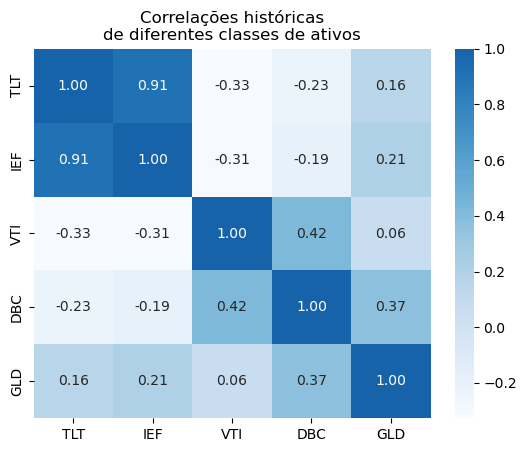

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8))
sns.heatmap(
    correlation_matrix, annot=True,
    center=0.5, fmt='.2f', cmap='Blues',
    ax=ax,
)
ax.set_title('Correlações históricas\nde diferentes classes de ativos')
fig.savefig('correlation_matrix.png')

#### Have they always been uncorrelated throughout time?

In [15]:
def build_correlation_series_between(ticker_a, ticker_b, window, assets_data):
    merged_returns_data = merge_two_assets_data(
        assets_data, ticker_a, ticker_b, column_to_use
    )
    return pd.Series({
        window_df.index[-1]: window_df.corr().loc[ticker_a, ticker_b]
        for window_df in merged_returns_data.rolling(window)
    })

In [16]:
window = 22
correlation_series_df = {
    f'{ticker_a} vs {ticker_b}': build_correlation_series_between(
        ticker_a, ticker_b, window, assets_data
    )
    for ticker_a, ticker_b in tqdm(combinations(fig_tickers, 2))
}

10it [00:19,  2.00s/it]


In [17]:
correlation_series_df = pd.DataFrame(correlation_series_df)

10it [00:00, ?it/s]
10it [00:00, ?it/s]


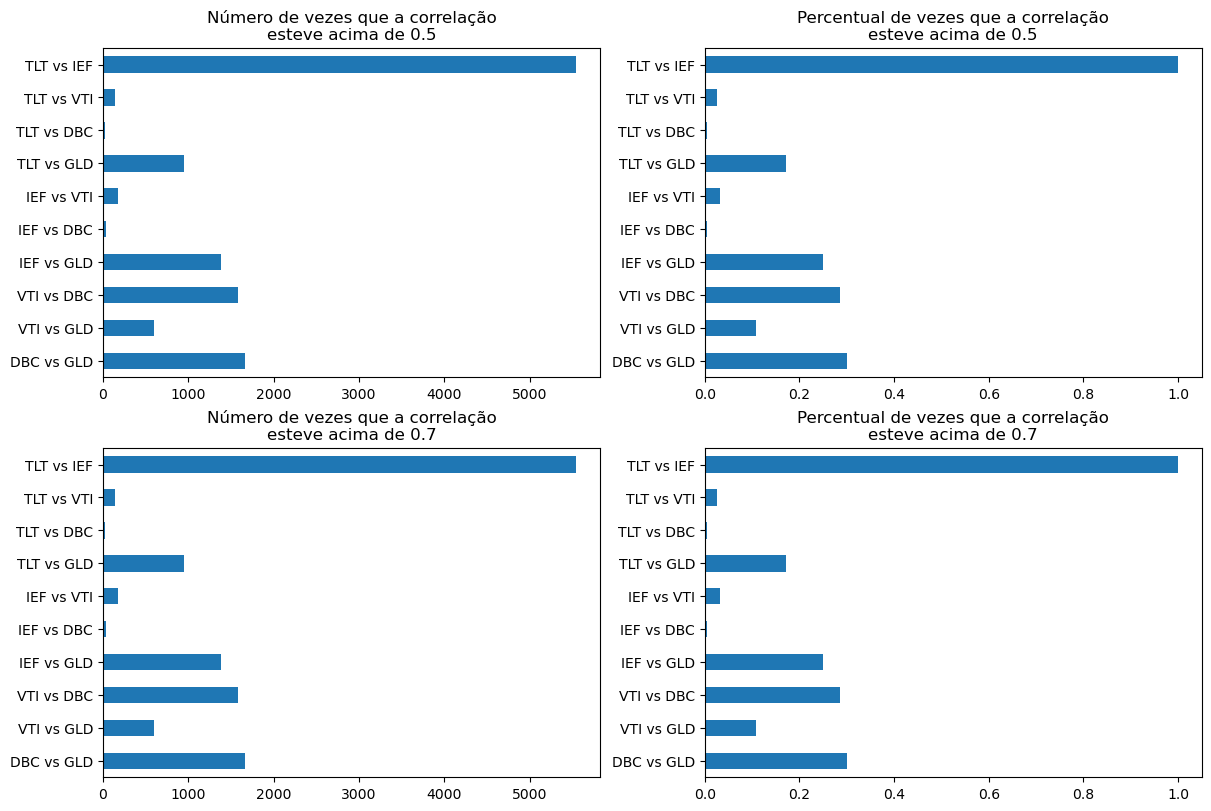

In [18]:
width = 6
height = 4
rows = 2
cols = 2
fig, axs = plt.subplots(rows, cols, figsize=(cols * width, rows * height,), constrained_layout=True)
axit = iter(axs.ravel())

for n, n_big in zip((.5, .7), (50, 70)):
    counts_over_50p = pd.DataFrame({
        f'Número de vezes que a correlação\nesteve acima de {n}': (correlation_series_df > 0.5).sum(),
        f'Percentual de vezes que a correlação\nesteve acima de {n}': (correlation_series_df > 0.5).sum() / correlation_series_df.shape[0],
    })
    
    index_order = [f'{ticker_a} vs {ticker_b}' for ticker_a, ticker_b in tqdm(combinations(fig_tickers, 2))]
    
    
    for col in counts_over_50p.columns:
        ax = counts_over_50p.loc[index_order[::-1], col].plot(kind='barh', ax=next(axit))
        ax.set_title(col);

fig.savefig('times_corr_higher_than_x.png')

#### Is the performance of the portfolio better than isolated assets or subsets?

In [19]:
def adjust_proportions(proportions):
    return proportions / proportions.sum()

In [20]:
portfolio_tickers = ('TLT', 'IEF', 'VTI', 'DBC', 'GLD')

In [21]:
portfolio_proportions = pd.Series({
    'TLT': 0.4,
    'IEF': 0.15,
    'VTI': 0.3,
    'DBC': 0.075,
    'GLD': 0.075,
})

In [22]:
column_to_use = 'DayToDay_Var'

In [23]:
returns_table = pd.DataFrame([pd.Series(assets_data[ticker][column_to_use], name=ticker) for ticker in portfolio_tickers]).T.dropna()
returns_table['Portfolio'] = (returns_table * portfolio_proportions).sum(axis=1)

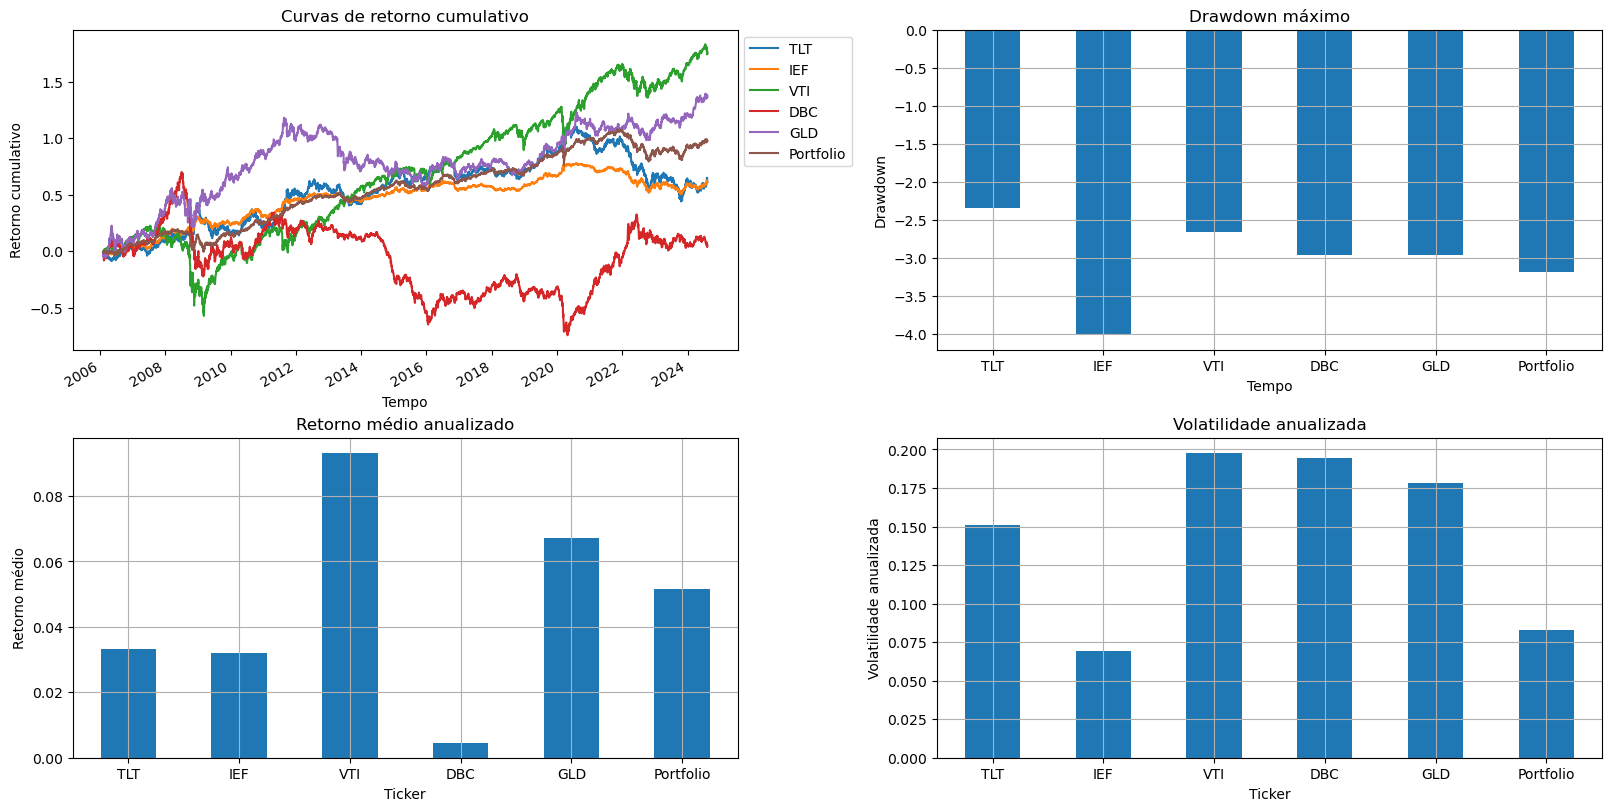

In [24]:
width = 8
height = 4
rows = 2
cols = 2
fig, axs = plt.subplots(rows, cols, figsize=(cols * width, rows * height), constrained_layout=True)
axit = iter(axs.ravel())

ax = next(axit)
ax = returns_table.cumsum().plot(ax=ax)
ax.set_title('Curvas de retorno cumulativo');
ax.set_xlabel('Tempo');
ax.set_ylabel('Retorno cumulativo');
ax.legend(bbox_to_anchor=(1, 1));

ax = next(axit)
ax = ((returns_table / returns_table.cummax()) - 1).min().plot(ax=ax, grid=True, kind='bar')
ax.set_title('Drawdown máximo');
ax.set_xlabel('Tempo');
ax.set_ylabel('Drawdown');
ax.set_xticklabels(ax.get_xticklabels(), rotation=0);

ax = next(axit)
(returns_table.rolling(252).sum().mean()).plot(kind='bar', grid=True, ax=ax)
ax.set_title('Retorno médio anualizado');
ax.set_xlabel('Ticker');
ax.set_ylabel('Retorno médio');
ax.set_xticklabels(ax.get_xticklabels(), rotation=0);

ax = next(axit)
(returns_table.std() * np.sqrt(252)).plot(kind='bar', grid=True, ax=ax)
ax.set_title('Volatilidade anualizada');
ax.set_xlabel('Ticker');
ax.set_ylabel('Volatilidade anualizada');
ax.set_xticklabels(ax.get_xticklabels(), rotation=0);

fig.savefig('big_panel.png')

#### Does it perform well at "every time"?

In [25]:
def analyse_performance_over(period, use_chunks=False):
    cols_to_use = returns_table.columns[:6]

    if use_chunks:
        returns_table['chunks'] = np.arange(returns_table.shape[0]) // period
        quarter_performance = returns_table[[*cols_to_use, 'chunks']].groupby('chunks').agg({
            col: 'sum' for col in cols_to_use
            if col != 'chunks'
        })
        quarter_performance.index = returns_table.groupby('chunks').head(1).index
    else:
        quarter_performance = pd.DataFrame([
            pd.Series(df.sum(), name=df.index[0])
            for df in returns_table[cols_to_use].rolling(period)
            if df.shape[0] == period
        ])

    portfolio = 'Portfolio'
    other_tickers = [col for col in quarter_performance.columns if col != 'Portfolio']
    
    quarter_performance['Portfolio foi positivo'] = quarter_performance[portfolio] > 0
    quarter_performance['Algum outro foi positivo'] = (quarter_performance[other_tickers] > 0).any(axis=1)
    quarter_performance['Ticker mais lucrativo'] = quarter_performance[[portfolio, *other_tickers]].idxmax(axis=1)
    quarter_performance['Portfolio no negativo e algum ativo no positivo'] = (~quarter_performance['Portfolio foi positivo']) & quarter_performance['Algum outro foi positivo']
    
    cols_to_count = [
        'Portfolio foi positivo',
        'Algum outro foi positivo',
        'Portfolio no negativo e algum ativo no positivo'
    ]
    
    counts = (pd.DataFrame({
        col: quarter_performance[col].value_counts(normalize=True)
        for col in cols_to_count
    }) * 100)
    
    return pd.Series(counts.T[True], name=f'Blocos de {period} dias')

In [26]:
def best_performer_over(period, use_chunks=False):
    cols_to_use = returns_table.columns[:6]

    if use_chunks:
        returns_table['chunks'] = np.arange(returns_table.shape[0]) // period
        quarter_performance = returns_table[[*cols_to_use, 'chunks']].groupby('chunks').agg({
            col: 'sum' for col in cols_to_use
            if col != 'chunks'
        })
        quarter_performance.index = returns_table.groupby('chunks').head(1).index
    else:
        quarter_performance = pd.DataFrame([
            pd.Series(df.sum(), name=df.index[0])
            for df in returns_table[cols_to_use].rolling(period)
            if df.shape[0] == period
        ])
    
    portfolio = 'Portfolio'
    other_tickers = [col for col in quarter_performance.columns if col != 'Portfolio']
    
    quarter_performance['Ativo mais lucrativo'] = quarter_performance[[portfolio, *other_tickers]].idxmax(axis=1)

    return pd.Series(quarter_performance['Ativo mais lucrativo'].value_counts(normalize=True), name=f'Blocos de {period} dias')

In [27]:
np.round(pd.DataFrame([
    analyse_performance_over(20),
    analyse_performance_over(60),
    analyse_performance_over(252),
    analyse_performance_over(252 * 3),
    analyse_performance_over(252 * 5),
    analyse_performance_over(252 * 10),
    analyse_performance_over(252 * 15),
]).fillna(0), 2)

,Portfolio foi positivo,Algum outro foi positivo,Portfolio no negativo e algum ativo no positivo
Blocos de 20 dias,64.36,96.16,31.80
Blocos de 60 dias,70.90,98.35,27.45
Blocos de 252 dias,78.33,99.64,21.31
Blocos de 756 dias,90.24,100.00,9.76
Blocos de 1260 dias,100.00,100.00,0.00
Blocos de 2520 dias,100.00,100.00,0.00
Blocos de 3780 dias,100.00,100.00,0.00


In [28]:
np.round(pd.DataFrame([
    best_performer_over(20),
    best_performer_over(60),
    best_performer_over(252),
    best_performer_over(252 * 3),
    best_performer_over(252 * 5),
    best_performer_over(252 * 10),
    best_performer_over(252 * 15),
]).fillna(0) * 100, 2)

Ativo mais lucrativo,VTI,DBC,TLT,GLD,IEF
Blocos de 20 dias,29.45,23.70,22.10,21.11,3.64
Blocos de 60 dias,33.75,22.68,20.07,21.99,1.50
Blocos de 252 dias,37.31,19.86,18.47,20.90,3.45
Blocos de 756 dias,51.87,14.97,5.89,27.22,0.05
Blocos de 1260 dias,74.10,4.03,3.41,18.45,0.00
Blocos de 2520 dias,89.38,0.00,8.75,1.87,0.00
Blocos de 3780 dias,100.00,0.00,0.00,0.00,0.00
